In [1]:
import sys 
sys.path.append('C:/Users/Administrator/Desktop/ETH/NeuralPlanes')

In [2]:
print(sys.path)
from NeuralPlanes.localization.map import NeuralMap, NeuralMapConf
from NeuralPlanes.localization.pose_scoring import score_pose
from NeuralPlanes.localization.unet import Unet
from NeuralPlanes.pipeline.lamar import *
from NeuralPlanes.pipeline.dataloader import *
from NeuralPlanes.plane import Planes, draw_planes
from NeuralPlanes.utils import select_device
from NeuralPlanes.camera import compute_ray
from matplotlib import pyplot as plt 
import copy
import umap

['/mnt/c/Users/Administrator/Desktop/ETH/NeuralPlanes', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python311.zip', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/lib-dynload', '', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages', '/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/tinycudann-1.7-py3.11-linux-x86_64.egg', 'C:/Users/Administrator/Desktop/ETH/NeuralPlanes']


In [3]:
device = select_device()

flip
flip
flip
flip


/mnt/c/Users/Administrator/Desktop/ETH/NeuralPlanes/NeuralPlanes/pipeline/lamar.py:303: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  normal = torch.cross(x1-x0, x2-x1)


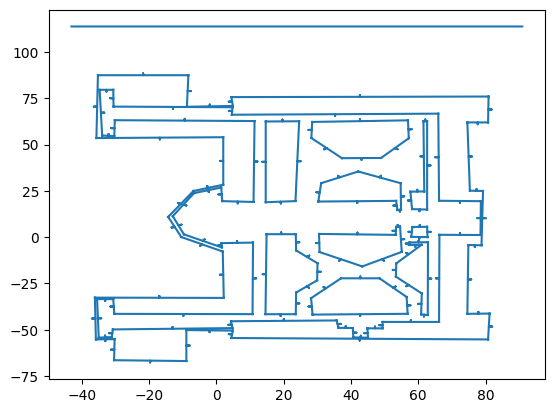

In [4]:
lamar_path = Path("data/HGE/HGE")
max_size = 256

session_map_path = lamar_path / "sessions" / "map"
session_map_image_path = session_map_path / "raw_data"
session_map_path_precompute = lamar_path / "sessions" / ("map_precompute_"+str(max_size))
session_map_path_depth = session_map_path_precompute / "depth"
session_map_path_small = session_map_path_precompute / "small_images"

images_raw = parse_session(session_map_path, lambda path: path.startswith("ios"))

floor_plan_img, plane_points, floorplan_to_world = parse_floorplan(lamar_path / "floor_plan")

fig, ax = plt.subplots()
plot_floor_planes(fig, ax, plane_points)


In [22]:
model_checkpoint = "NeuralPlanes/pipeline/checkpoint/model.pt"

conf = NeuralMapConf(num_components=4, num_features_backbone=21, num_features=16, depth_sigma=0.2)
encoder = Unet(encoder_freeze=True, classes= conf.num_features, backbone_name='resnet18')

map = load_map(model_checkpoint, encoder, conf, 1032, 631)

encoder = encoder.to(device)

/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


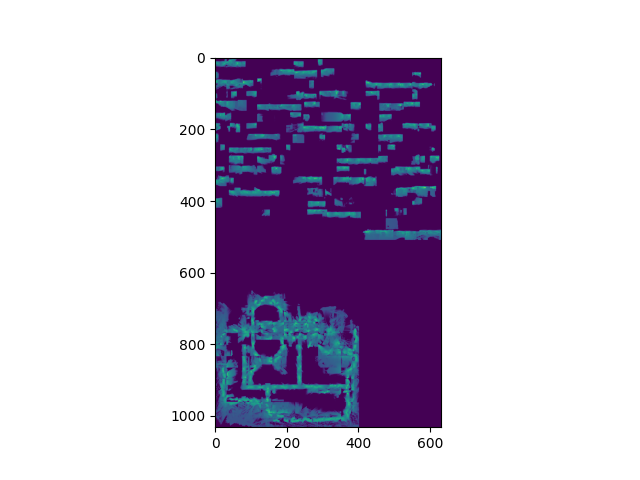

In [23]:
fig = plt.figure()
plt.imshow(map.atlas_weight.cpu())
plt.show()

tensor(0., device='cuda:0') tensor(3.0306, device='cuda:0')
tensor(0.2252, device='cuda:0') tensor(3.0306, device='cuda:0')


/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


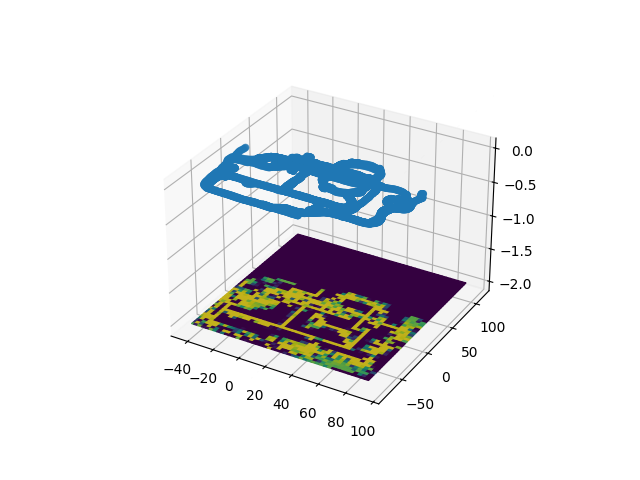

In [7]:
%matplotlib widget 

from math import ceil

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

print(map.atlas_weight.min(), map.atlas_weight.max())

xs = []
for image in images_raw:
    x = image.camera.t
    xs.append(x)
xs = np.array(xs)

print(map.atlas_weight.mean(), map.atlas_weight.max())
ax.scatter(xs[:,0], xs[:,1])
draw_planes(ax, map.planes.cpu(), color= map.atlas_weight, indices=[0], vmin=0.0, vmax= 1, stride=1)

In [8]:

cameras, images_small, images_depth = get_preprocessed_images(images_raw, session_map_path_small, session_map_path_depth, max_size)

print("Map images ", len(images_raw))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7553/7553 [01:16<00:00, 98.54it/s]

Map images  7553


Using cache found in /home/goetzl/.cache/torch/hub/yvanyin_metric3d_main
xFormers not available
xFormers not available
xFormers not available
xFormers not available
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1920, 1440)


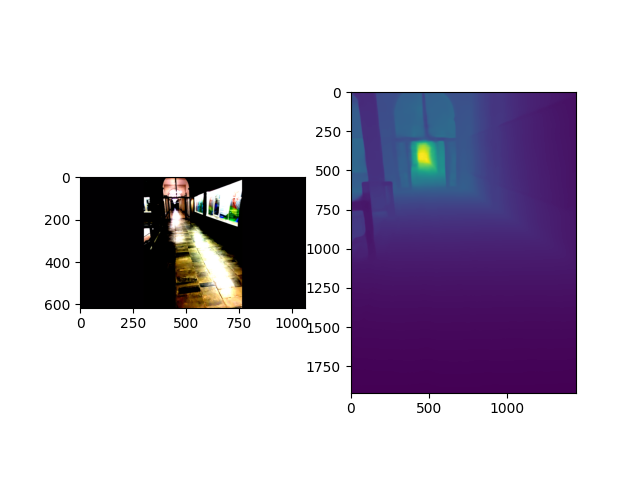

In [9]:
image = images_raw[1300]
model = MonocularDepthModel()
model = model.to(device)

data = collate_fn(compose([model.preprocess]))([image])

data = {k: v.to(device) if isinstance(v,torch.Tensor) else v for k,v in data.items()}

result = model(data)
depth = result["image"][0].detach().cpu().numpy()
print(depth.shape)

fig, axs = plt.subplots(1,2)
axs[0].imshow(data["rgb"][0].detach().cpu().permute(1,2,0))
axs[1].imshow(depth)


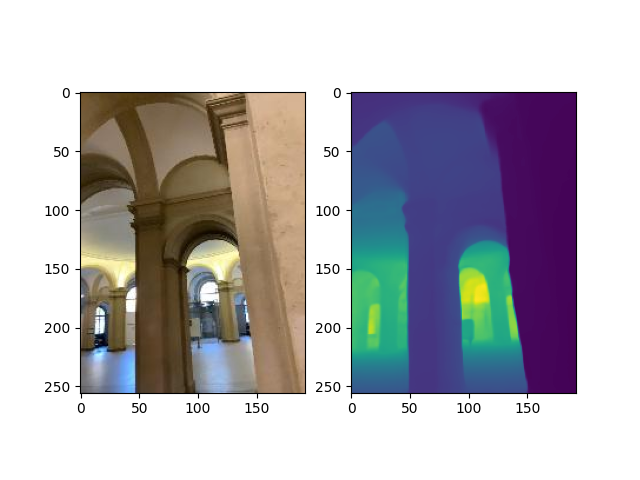

In [10]:
image_id = 1100
fig, ax = plt.subplots(1,2)
ax[0].imshow(images_small[image_id]['image'])
ax[1].imshow(images_depth[image_id]['image'])

In [11]:
image_id = 1100
image = images_small[image_id]
image_torch = encoder.preprocess(image)["image"]
depth = images_depth[image_id]["image"][:,:,0]
depth_torch = torch.tensor(depth, dtype=torch.float, device=device)

print(image_torch.shape)

map = map.to(device)
features = map.encode({"image": image_torch[None].to(device) }, depth_torch[None].to(device))[0]

weight, rem_features = features[0,:,:], features[1:,:,:]
print(weight.min(), weight.max(), rem_features.min(), rem_features.max())


torch.Size([3, 256, 192])
tensor(0.9965, device='cuda:0', grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.6560, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6267, device='cuda:0', grad_fn=<MaxBackward1>)


In [12]:
feat_np = rem_features.permute(1,2,0).detach().cpu().numpy()
mapper = umap.UMAP(n_components=3).fit(feat_np.reshape(-1,conf.num_features))

/home/goetzl/miniconda3/envs/robo_ml_wsl/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 192, 3)
tensor(0.9965, device='cuda:0', grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


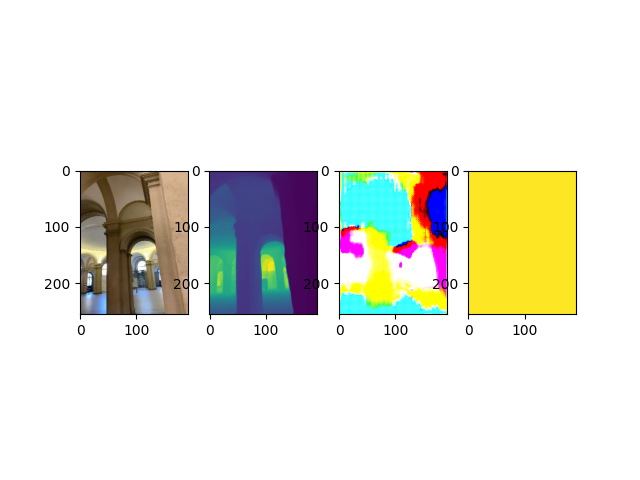

In [13]:
fig, axes = plt.subplots(1,4)
height,width,c = image["image"].shape 
print((height,width,c))
print(weight.min(), weight.max())
axes[0].imshow(image["image"])
axes[1].imshow(depth)
axes[2].imshow(mapper.embedding_.reshape(height,width,3))
axes[3].imshow(weight.cpu().detach().numpy(), vmin=0.95, vmax=1)

In [24]:
print("Image=", rem_features.mean(), "Max depth=", depth.max())

planes = map.planes
map = map.to(device)
map = map.eval()

x00 = planes.x0s[0] 
x01 = planes.x0s[0] + planes.us[0]
x10 = planes.x0s[0] + planes.vs[0]
x11 = planes.x0s[0] + planes.us[0] + planes.vs[0]

div = 60
div_rot = 1
cam = image["camera"]
xs,ys,thetas = torch.meshgrid(torch.linspace(x00[0], x01[0], div), torch.linspace(x01[1], x11[1], div), torch.linspace(0, 2*torch.pi, div_rot)) 
xs,ys,thetas = xs.flatten(),ys.flatten(),thetas.flatten()

print(cam.size, image["image"].shape)

scores = torch.zeros(len(xs))
weights = torch.zeros(len(xs))

print("Features=", features.shape)

scale_factor = 1.0/8
cam = cam.scale(scale_factor)
feature_small = torch.nn.functional.interpolate(features[None], scale_factor=scale_factor)[0]
depth_small = torch.nn.functional.interpolate(depth_torch[None, None], scale_factor=scale_factor)[0,0]

R_canon, t_canon = cam.R, torch.tensor([0,0,cam.t[2]])

with torch.no_grad():
    for i, (x,y,theta) in enumerate(zip(tqdm.tqdm(xs),ys,thetas)):
        new_cam = copy.copy(cam)
        new_cam.t = t_canon + torch.tensor([x,y,0])
        
        R = torch.tensor([
            [torch.cos(theta), -torch.sin(theta), 0],
            [torch.sin(theta), torch.cos(theta), 0,],
            [0, 0, 1]
        ])
        
        new_cam.R = R @ R_canon @ R.T
        new_cam.t = t_canon + torch.tensor([x,y,0])
        new_cam = new_cam.to(device)
        #print(new_cam.size.device,new_cam.R.device, map.planes.x0s.device, features.device, depth_small.device)
        plane_indices = torch.arange(1,device=device) 
        score, weight = score_pose(map, new_cam, feature_small, depth_small, plane_indices=plane_indices, rel_x0=torch.zeros((len(plane_indices),2),device=device), rel_x1=torch.ones((len(plane_indices),2),device=device))
        #print(score, feature_small.mean(), depth_small.mean())
        #plane_indices=torch.tensor([0])) # plane_indices=torch.tensor([0]))
        scores[i] = score
        weights[i] = weight
    scores = scores.reshape((div,div,div_rot))
    weights = weights.reshape((div,div,div_rot))
    xs = xs.reshape((div,div,div_rot))
    ys = ys.reshape((div,div,div_rot))
    theta = thetas.reshape((div,div,div_rot))

print(scores.mean(), scores.max())

Image= tensor(0.0029, device='cuda:0', grad_fn=<MeanBackward0>) Max depth= 15.914
tensor([192, 256]) (256, 192, 3)
Features= torch.Size([17, 256, 192])


  0%|                                                                                                                                                                                                                                          | 0/3600 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3600/3600 [00:19<00:00, 182.12it/s]

tensor(9.6249) tensor(69.9229)


In [15]:
print(map.positional.alpha)

Parameter containing:
tensor(-1., device='cuda:0', requires_grad=True)


tensor([16.7547, 14.5627,  1.7477])
score at pos  tensor(24.3483, device='cuda:0', grad_fn=<DivBackward0>) tensor(1.3623, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([60, 60, 1]) torch.Size([60, 60])
33.303463
torch.Size([3600]) torch.Size([3600])
NExt


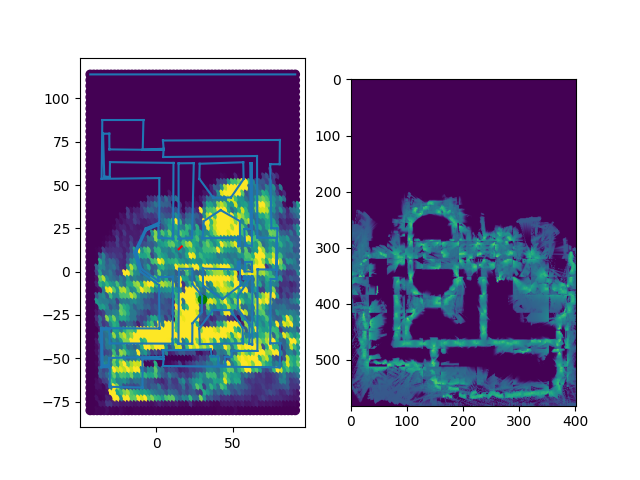

In [25]:
gt = cam.t
print(gt)

#prob, dense, eval = score_pose(map, cam, feature_small, depth_small, plane_indices=torch.tensor([0]), dense=True)
score, weight = score_pose(map, cam.to(device), feature_small, depth_small, plane_indices=torch.tensor([0])) # rel_x0=rel_x0[None], rel_x1=rel_x1[None])
print("score at pos ", score, weight)

final_scores = (scores.cpu()).max(dim=2)[0] 
final_scores = final_scores.detach()
print(xs.shape, final_scores.shape)
avg_x = (xs[:,:,0] * final_scores).sum() / final_scores.sum()
avg_y = (ys[:,:,0] * final_scores).sum() / final_scores.sum() 

print(np.linalg.norm(np.array([avg_x,avg_y]) - np.array([gt[0],gt[1]])))
#scores = torch.where(weights > 0.4, scores, torch.tensor(0.0))

fig, ax = plt.subplots(1,2)

planes = map.planes
points = [] 
for i in range(len(map.planes)):
    x0 = planes.x0s[i]
    x1 = planes.x0s[i] + planes.us[i]
    points.append(x0[:2])
    points.append(x1[:2])
    points.append(torch.tensor([torch.inf,torch.inf],device=device))
points = torch.stack(points)
points = points.cpu()
final_scores = final_scores.cpu()

print(xs[:,:,0].flatten().shape, final_scores.flatten().shape)
ax[0].scatter(xs[:,:,0].flatten(),ys[:,:,0].flatten(), c= final_scores.flatten(), vmin=0, vmax=30) # vmin=0, vmax=0.3) #, vmin=0.4, vmax=0.8)
print("NExt")
o, dir = compute_ray(1,1,cam,'cpu')

p = o[0,0] + 3*dir[0,0]

ax[0].plot([gt[0].item(), p[0].item()], [gt[1].item(), p[1].item()], color="red")
ax[0].scatter([avg_x.item()], [avg_y.item()], color="green")

ax[0].plot(points[:,0], points[:,1])

coord, coord_size = map.planes.coord_x0[0], map.planes.coord_size[0]
coord = coord.type(torch.int)
coord_size = coord_size.type(torch.int)
atlas_weight = map.atlas_weight[coord[1]:coord[1]+coord_size[1], coord[0]:coord[0]+coord_size[0]]
ax[1].imshow(atlas_weight.cpu().numpy())

torch.Size([130, 2]) torch.Size([130, 2])
tensor([  0., 450.], device='cuda:0')
780


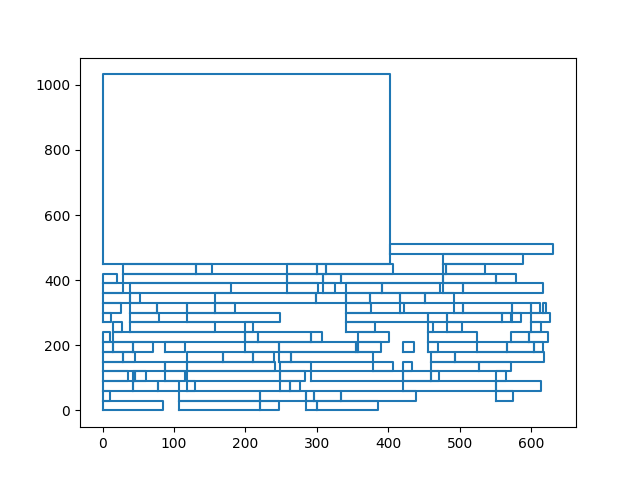

In [17]:
planes = map.planes 

x0 = planes.coord_x0
x1 = x0 + planes.coord_size

print(x0.shape, x1.shape)

n = len(x0)

rects = torch.zeros((6, n, 2))
rects[0] = x0
rects[1] = torch.stack([x1[:,0], x0[:,1]], dim=1)
rects[2] = torch.stack([x1[:,0], x1[:,1]], dim=1)
rects[3] = torch.stack([x0[:,0], x1[:,1]], dim=1)
rects[4] = x0
rects[5] = torch.inf

print(planes.coord_x0[0])

rects = rects.permute(1,0,2).reshape((-1,2))

print(len(rects))
fig, ax = plt.subplots(1,1)
plt.plot(rects[:,0], rects[:,1])
plt.show()

In [18]:
map.planes.x0s[0], map.planes.planes[0][0:3], map.planes.us[0][0:3], map.planes.vs[0][0:3]

(tensor([ 90.9082, 113.8622,  -2.0000], device='cuda:0'),
 tensor([0., 0., 1.], device='cuda:0'),
 tensor([-134.,    0.,    0.], device='cuda:0'),
 tensor([   0., -194.,    0.], device='cuda:0'))